# Active catheter tracking notebook: test run
To run the full pipeline from raw data download through reconstruction and analysis requires resources that may not be available depending on your setup: about 5 GB storage and about 50 minutes on a single processor (much less time required for a multi-processor system). On cloud notebooks, these resources may not be available, in which case, skip to the analysis section, which uses precomputed outputs from the reconstruction and localization.

The notebook is broken down into:
- Download the raw tracking projections from each experiment
- Reconstruct
- Localize the coils using each algorithm
- Verify the results against preprocessed data
- Analysis: Run the static and dynamic analysis notebooks. Output is shown here

# Download dataset from Zenodo

Test [zenodo_get](https://github.com/dvolgyes/zenodo_get) to download a subset of a dataset, with record #10676292. The "-g" option specifies the pattern we're looking for. Until our dataset is uploaded, testing things with a random dataset:

In [5]:
!zenodo_get -g ROIs.zip 10676292

Title: A Detailed 3D MRI Brain Atlas of the African Lungfish Protopterus annectens
Keywords: Brain, Atlas, 3D, Lungfish, Protopterus, Neuroanatomy, MRI, Magnetic resonance imaging
Publication date: 2024
DOI: 10.5281/zenodo.10676292
Total size: 2.3 MB

Link: https://zenodo.org/records/10676292/files/ROIs.zip   size: 2.3 MB
100% [......................................................] 2342882 / 2342882
Checksum is correct. (8613a410bd6b4fbb134b5685adeea171)
All files have been downloaded.


The above ROIs.zip won't be used, delete it:

In [6]:
!rm ROIs.zip

**Warning** Download of the active tracking raw data requires approximately 5 GB of space. If you prefer, skip ahead to the analysis section which uses the precomputed outputs.

# Run localization algorithms on raw data
**Warning:** this step is very slow and can take an hour. To use precomputed outputs instead, skip to the analysis section.

Test cathy localize:
- run "cathy localize" on raw projection data: this will generate coordinate output in text files from each of the localization algorithms
- ex/ cathy localize -d 6 -p 7 input_dir output_dir
    - runs the algorithm for coils 6 (distal) and 7 (proximal) for the projection files under "input_dir"
    - output_dir will contain subdirectories for each of the algorithms (peak, centroid, centroid_around_peak, png, jpng)
    - each algorithm subdirectory will contain a coordinate text output file for each coil

for this test:
- input_dir: /data/activeTracking-reorg1/data/raw/static/trackTest-13Dec2021-C306-Y0/1/FH512_noDither_gradSpoiled-2021-12-13T13_02_33.756
- output_dir: /data/localize_c306-y0-1-fh

In [7]:
import csv
import pathlib
import os
import multiprocessing as mp
import shutil
import hashlib
from ipywidgets import IntProgress
from IPython.display import display

In [8]:
note_dir = os.getcwd()
note_dir

'/code'

In [9]:
mp.cpu_count()

24

In [10]:
!cathy localize -d 6 -p 7 /data/activeTracking-reorg1/data/raw/static/trackTest-13Dec2021-C306-Y0/1/FH512_noDither_gradSpoiled-2021-12-13T13_02_33.756 /data/localize_c306-y0-1-fh 

--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using peak
[0] processing using centroid
[0] processing using centroid_around_peak
[0] processing using png
[0] processing using jpng


Test the equivalent regular python method, with option to set which algorithms to run:

In [11]:
import cathy.cli as cat
src = '/data/activeTracking-reorg1/data/raw/static/trackTest-13Dec2021-C306-Y0/1/FH512_noDither_gradSpoiled-2021-12-13T13_02_33.756'
dst = '/data/loc_c306-y0-1-fh'
cat.run_localize(src,dst,6,7,1,0,['centroid_around_peak', 'jpng'])

--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using centroid_around_peak
[0] processing using jpng


The full list of raw data directories is in the included csv file.

In [12]:
recordings_csv = note_dir + '/data/meta/catheter_raw_recordings.csv'
prepend = '/data/activeTracking-reorg1/data/' # Set this to 'data/' after get from zenodo

The below cell will reconstruct all the raw data and run the localization algorithms using a single cpu: this will be slow. On non-binder instance: Skip this and run the next two cells to distribute the work across cpus & finish faster.

```python
%%time

directory_list = [] # list of preprocessed & processed output directory tuples
doRun = True # True to run cathy localize: ow/ will fill in the directory list but not run cathy

with open(recordings_csv,'r') as csvfile:
    rdr = csv.DictReader(csvfile)
    for row in rdr:
        raw_dir = pathlib.PurePath(row['Input'])
        source = pathlib.PurePath(prepend).joinpath(raw_dir)
        distal = int(row['distal'])
        proximal = int(row['proximal'])
        dest = pathlib.PurePath(prepend).joinpath('processed').joinpath(pathlib.PurePath(*raw_dir.parts[1:]))
        preproc = pathlib.PurePath(prepend).joinpath('preprocessed').joinpath(pathlib.PurePath(*raw_dir.parts[1:]))
        directory_list.append( (preproc,dest))
        print('source: ' + str(source))
        print('dest: ' + str(dest))
        if doRun:
            os.makedirs(dest, exist_ok=True)
            # !cathy localize -d {distal} -p {proximal} {source} {dest}
            cat.run_localize(source, dest, distal, proximal, algos=['centroid_around_peak', 'png', 'jpng'])
```

In [13]:
def call_localize(args):
    assert(len(args[0]) == 4), "Parameter issue: " + str(args)
    src = args[0][0]
    dst = args[0][1]
    dist = args[0][2]
    prox = args[0][3]
    print("run src: " + str(src) + ", dest: " + str(dst) + ", distal: " + str(dist) + ", proximal: " + str(prox))
    cat.run_localize(src, dst, dist, prox, algos=['centroid_around_peak', 'png', 'jpng'])

In [14]:
print(os.getenv("CPU_LIMIT"))

None


In [15]:
%%time
data_tuples = [] # list of preprocessed & processed output directories and coil args
doRun = True # True to run cathy localize: ow/ will fill in the data_tuples but not run localize

#new_dir_list = [] #compare reorg processed directory to repo preprocessed directory (we added png back in)
repo_dir = note_dir + '/data/'

cpu_limit_env = os.getenv("CPU_LIMIT")
if cpu_limit_env is None:
    cpu_count = mp.cpu_count()
else:
    cpu_count = cpu_limit_env
# set up the localize arguments based on the spreadsheet:
with open(recordings_csv,'r') as csvfile:
    rdr = csv.DictReader(csvfile)
    for row in rdr:
        raw_dir = pathlib.PurePath(row['Input'])
        source = pathlib.PurePath(prepend).joinpath(raw_dir)
        distal = int(row['distal'])
        proximal = int(row['proximal'])
        dest = pathlib.PurePath(prepend).joinpath('processed').joinpath(pathlib.PurePath(*raw_dir.parts[1:]))
        data_tuples.append( (source, dest, distal, proximal))
        preproc = pathlib.PurePath(repo_dir).joinpath('preprocessed').joinpath(pathlib.PurePath(*raw_dir.parts[1:]))
        #new_dir_list.append( (preproc,dest))
        os.makedirs(dest, exist_ok=True)

# data_tuples contains our arguments: we can split the processing across cpus for performance
print("Running localize on " + str(len(data_tuples)) + " directories")
pool = mp.Pool(mp.cpu_count())
if doRun:
    result = pool.map( call_localize, [data_tuples[i:i+1] for i in range(0,len(data_tuples))] )

Running localize on 293 directories
run src: /data/activeTracking-reorg1/data/raw/dynamic/catheter306/unfiltered/3P, dest: /data/activeTracking-reorg1/data/processed/dynamic/catheter306/unfiltered/3P, distal: 6, proximal: 7run src: /data/activeTracking-reorg1/data/raw/dynamic/catheter231/unfiltered/3P, dest: /data/activeTracking-reorg1/data/processed/dynamic/catheter231/unfiltered/3P, distal: 6, proximal: 7run src: /data/activeTracking-reorg1/data/raw/static/trackTest-13Dec2021-C306-Y0/7/FH512_noDither_gradSpoiled-2021-12-13T14_30_58.537, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-13Dec2021-C306-Y0/7/FH512_noDither_gradSpoiled-2021-12-13T14_30_58.537, distal: 6, proximal: 7run src: /data/activeTracking-reorg1/data/raw/static/trackTest-13Dec2021-C306-Y0/9/FH512_noDither_gradSpoiled-2021-12-13T14_54_28.767, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-13Dec2021-C306-Y0/9/FH512_noDither_gradSpoiled-2021-12-13T14_54_28.767, distal: 6, proximal: 7

[0] pre-processing data



[0] pre-processing data
[0] pre-processing data
[0] pre-processing data

[0] pre-processing data
[0] pre-processing data

[0] processing using centroid_around_peak
[0] processing using centroid_around_peak[0] processing using centroid_around_peak
[0] processing using centroid_around_peak
[0] processing using centroid_around_peak[0] processing using centroid_around_peak[0] processing using centroid_around_peak

[0] processing using centroid_around_peak[0] processing using centroid_around_peak
[0] processing using centroid_around_peak


[0] processing using centroid_around_peak
[0] processing using centroid_around_peak
[0] processing using centroid_around_peak

[0] processing using centroid_around_peak[0] processing using centroid_around_peak[0] processing using centroid_around_peak


[0] processing using centroid_around_peak[0] processing using centroid_around_peak

[0] processing using centroid_around_peak
[0] processing using centroid_around_peak
[0] process

[0] pre-processing data
[0] processing using png[0] processing using jpng

[0] processing using centroid_around_peak
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-15Dec2021-C231-Y0/7/SRI_Original-2021-12-15T15_54_48.938, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-15Dec2021-C231-Y0/7/SRI_Original-2021-12-15T15_54_48.938, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[1] processing using jpngrun src: /data/activeTracking-reorg1/data/raw/static/trackTest-15Dec2021-C231-Y0/1/SRI_Original-2021-12-15T14_46_35.548, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-15Dec2021-C231-Y0/1/SRI_Original-2021-12-15T14_46_35.548, distal: 6, proximal: 7

--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using png
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-13Dec2021-C306-Y0/9/SRI_Original-2021-12-13T14_55_19.339, dest: /data/activeTracking-reorg1/data/processed/static/tra

run src: /data/activeTracking-reorg1/data/raw/static/trackTest-15Dec2021-C231-Y0/12/FH512_noDither_gradSpoiled-2021-12-15T17_11_08.948, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-15Dec2021-C231-Y0/12/FH512_noDither_gradSpoiled-2021-12-15T17_11_08.948, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using jpng
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-17Aug2021-C222-Y0/4/SRI_Original-2021-08-17T11_42_35.873, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-17Aug2021-C222-Y0/4/SRI_Original-2021-08-17T11_42_35.873, distal: 4, proximal: 5
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using centroid_around_peak
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-17Aug2021-C222-Y0/16/FH512_noDither_gradSpoiled-2021-08-17T16_59_02.264, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-17Aug2021-C222-Y0/16/FH512_noDither_gradSpoiled-

run src: /data/activeTracking-reorg1/data/raw/static/trackTest-15Dec2021-C231-Y0/12/SRI_Original-2021-12-15T17_11_58.462, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-15Dec2021-C231-Y0/12/SRI_Original-2021-12-15T17_11_58.462, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using png
[0] processing using jpng
[0] processing using centroid_around_peak
[0] processing using jpngrun src: /data/activeTracking-reorg1/data/raw/static/trackTest-17Aug2021-C222-Y0/10/FH512_noDither_gradSpoiled-2021-08-17T14_48_20.421, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-17Aug2021-C222-Y0/10/FH512_noDither_gradSpoiled-2021-08-17T14_48_20.421, distal: 4, proximal: 5

--- -- -- -- -- -- -- -- -- -- --
[0] processing using centroid_around_peak[0] pre-processing data

run src: /data/activeTracking-reorg1/data/raw/static/trackTest-17Aug2021-C222-Y0/9/FH512_noDither_gradSpoiled-2021-08-17T14_29_04.451, dest: /data/activeTr

run src: /data/activeTracking-reorg1/data/raw/static/trackTest-21Dec2021-C231-Y1/3/FH512_noDither_gradSpoiled-2021-12-21T14_16_58.679, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-21Dec2021-C231-Y1/3/FH512_noDither_gradSpoiled-2021-12-21T14_16_58.679, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-21Dec2021-C231-Y1/5/FH512_noDither_gradSpoiled-2021-12-21T14_45_54.917, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-21Dec2021-C231-Y1/5/FH512_noDither_gradSpoiled-2021-12-21T14_45_54.917, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using centroid_around_peak
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-13Dec2021-C306-Y0/2/SRI_Original-2021-12-13T13_25_57.424, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-13Dec2021-C306-Y0/2/SRI_Original-2021-12-13T13_25_57.424, dista

--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using centroid_around_peak
[0] processing using centroid_around_peak
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-21Dec2021-C231-Y1/5/SRI_Original-2021-12-21T14_46_41.250, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-21Dec2021-C231-Y1/5/SRI_Original-2021-12-21T14_46_41.250, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using jpng
[0] processing using jpng
[0] processing using centroid_around_peak
[0] processing using centroid_around_peak
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-6Jan2022-C306-Y1/11/SRI_Original-2022-01-06T14_37_17.904, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-6Jan2022-C306-Y1/11/SRI_Original-2022-01-06T14_37_17.904, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using png
run src: /data/activeTracking-reorg1/data/raw

run src: /data/activeTracking-reorg1/data/raw/static/trackTest-7Jan2022-C306-Y2/1/FH512_noDither_gradSpoiled-2022-01-07T13_19_44.256, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-7Jan2022-C306-Y2/1/FH512_noDither_gradSpoiled-2022-01-07T13_19_44.256, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using centroid_around_peak
[0] processing using jpng
[0] processing using jpng
[0] processing using png
[0] processing using jpng
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-6Jan2022-C306-Y1/1/SRI_Original-2022-01-06T12_08_10.979, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-6Jan2022-C306-Y1/1/SRI_Original-2022-01-06T12_08_10.979, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using centroid_around_peak
[0] processing using png
[0] processing using png[0] processing using centroid_around_peak

[0] processing using jpng
run src: /data/acti

run src: /data/activeTracking-reorg1/data/raw/static/trackTest-6Jan2022-C306-Y1/6/FH512_noDither_gradSpoiled-2022-01-06T13_18_11.660, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-6Jan2022-C306-Y1/6/FH512_noDither_gradSpoiled-2022-01-06T13_18_11.660, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-21Dec2021-C231-Y1/16/SRI_Original-2021-12-21T18_19_59.635, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-21Dec2021-C231-Y1/16/SRI_Original-2021-12-21T18_19_59.635, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --[1] processing using centroid_around_peak

[0] pre-processing data
[0] processing using centroid_around_peak
[0] processing using centroid_around_peak
[0] processing using jpng
[0] processing using jpng
[0] processing using centroid_around_peak
[0] processing using jpng
[0] processing using centroid_around_peak
[1] processing using png
[0] pro

[0] processing using centroid_around_peak
[0] processing using centroid_around_peak
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-7Jan2022-C306-Y2/10/FH512_noDither_gradSpoiled-2022-01-07T16_04_53.697, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-7Jan2022-C306-Y2/10/FH512_noDither_gradSpoiled-2022-01-07T16_04_53.697, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] processing using png
[0] pre-processing data
[0] processing using png
[0] processing using png
[0] processing using centroid_around_peak
[0] processing using jpng
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-7Jan2022-C306-Y2/6/FH512_noDither_gradSpoiled-2022-01-07T15_18_22.329, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-7Jan2022-C306-Y2/6/FH512_noDither_gradSpoiled-2022-01-07T15_18_22.329, distal: 6, proximal: 7
[0] processing using png
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
run src: /data/activeTracking-reorg1/data/

run src: /data/activeTracking-reorg1/data/raw/static/trackTest-8Nov2021-C222-Y1/7/SRI_Original-2021-11-08T17_41_29.242, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-8Nov2021-C222-Y1/7/SRI_Original-2021-11-08T17_41_29.242, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-7Jan2022-C306-Y2/6/SRI_Original-2022-01-07T15_19_11.911, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-7Jan2022-C306-Y2/6/SRI_Original-2022-01-07T15_19_11.911, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using png
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-7Jan2022-C306-Y2/10/SRI_Original-2022-01-07T16_05_41.446, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-7Jan2022-C306-Y2/10/SRI_Original-2022-01-07T16_05_41.446, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[

run src: /data/activeTracking-reorg1/data/raw/static/trackTest-8Nov2021-C222-Y1/6/FH512_noDither_gradSpoiled-2021-11-08T17_29_07.501, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-8Nov2021-C222-Y1/6/FH512_noDither_gradSpoiled-2021-11-08T17_29_07.501, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-8Nov2021-C222-Y1/10/FH512_noDither_gradSpoiled-2021-11-08T18_32_49.035, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-8Nov2021-C222-Y1/10/FH512_noDither_gradSpoiled-2021-11-08T18_32_49.035, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using centroid_around_peak
[0] processing using jpng
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-8Nov2021-C222-Y1/16/FH512_noDither_gradSpoiled-2021-11-08T19_47_53.592, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-8Nov2021-C222-Y1/16/FH512

run src: /data/activeTracking-reorg1/data/raw/static/trackTest-9Jan2022-C231-Y2/12/SRI_Original-2022-01-09T17_09_14.726, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-9Jan2022-C231-Y2/12/SRI_Original-2022-01-09T17_09_14.726, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using png
[0] processing using png
[0] processing using jpng
[0] processing using jpng
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-7Jan2022-C306-Y2/9/FH512_noDither_gradSpoiled-2022-01-07T15_52_48.488, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-7Jan2022-C306-Y2/9/FH512_noDither_gradSpoiled-2022-01-07T15_52_48.488, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --[0] processing using centroid_around_peak

[0] pre-processing datarun src: /data/activeTracking-reorg1/data/raw/static/trackTest-9Jan2022-C231-Y2/16/FH512_noDither_gradSpoiled-2022-01-09T17_55_10.894, dest: /data/activeTracking-reorg1/data/proce

[0] processing using jpng
[0] processing using jpng
[0] processing using jpng
[0] processing using png
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-8Nov2021-C222-Y1/7/FH512_noDither_gradSpoiled-2021-11-08T17_40_42.146, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-8Nov2021-C222-Y1/7/FH512_noDither_gradSpoiled-2021-11-08T17_40_42.146, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using jpng
[0] processing using centroid_around_peak
[0] processing using png
[0] processing using jpng
[0] processing using jpng
[0] processing using jpng
[0] processing using jpng
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-9Nov2021-C222-Y2/1/SRI_Original-2021-11-09T15_13_44.242, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-9Nov2021-C222-Y2/1/SRI_Original-2021-11-09T15_13_44.242, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
run src: /data/activeTra

[0] processing using jpng
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-9Jan2022-C231-Y2/3/FH512_noDither_gradSpoiled-2022-01-09T15_07_01.893, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-9Jan2022-C231-Y2/3/FH512_noDither_gradSpoiled-2022-01-09T15_07_01.893, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using jpng
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-9Nov2021-C222-Y2/16/FH512_noDither_gradSpoiled-2021-11-09T18_46_11.249, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-9Nov2021-C222-Y2/16/FH512_noDither_gradSpoiled-2021-11-09T18_46_11.249, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using jpng
[0] processing using jpng
[0] processing using centroid_around_peak
[0] processing using centroid_around_peak
[0] processing using png
[0] processing using png
run src: /data/activeTracking-reorg1/data/raw/static/tra

run src: /data/activeTracking-reorg1/data/raw/static/trackTest-9Nov2021-C222-Y2/6/SRI_Original-2021-11-09T16_31_05.932, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-9Nov2021-C222-Y2/6/SRI_Original-2021-11-09T16_31_05.932, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using jpng
[0] processing using png
[0] processing using centroid_around_peak
[0] processing using jpng
[0] processing using jpng
[0] processing using png
[0] processing using jpng
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-9Nov2021-C222-Y2/2/SRI_Original-2021-11-09T15_31_17.190, dest: /data/activeTracking-reorg1/data/processed/static/trackTest-9Nov2021-C222-Y2/2/SRI_Original-2021-11-09T15_31_17.190, distal: 6, proximal: 7
--- -- -- -- -- -- -- -- -- -- --
[0] pre-processing data
[0] processing using centroid_around_peak
[0] processing using png
[0] processing using jpng
run src: /data/activeTracking-reorg1/data/raw/static/trackTest-

In [16]:
import os
print(os.cpu_count())

24


# Copy ground truth data to processed directory
Ground truth files are expected in the processed directory for later analysis. These should be copied from the raw subdirectories to the corresponding processed subdirectories. A list of these files is in meta/gt_files.txt

In [17]:
gtf = open(note_dir + '/data/meta/gt_files.txt','r')
gt_list = gtf.readlines()
for gt_file in gt_list:
    gt_path = pathlib.PurePath(gt_file.rstrip())
    src = pathlib.PurePath(prepend).joinpath(gt_path)
    dest = pathlib.PurePath(prepend).joinpath('processed').joinpath(pathlib.PurePath(*gt_path.parts[1:]))
    dest_dir = pathlib.PurePath(*dest.parts[:-1])
    print('dest dir: ' + str(dest_dir))
    os.makedirs(dest_dir, exist_ok=True)
    print('cp ' + str(src) + ' ' + str(dest))
    shutil.copyfile(src,dest)
    

dest dir: /data/activeTracking-reorg1/data/processed/dynamic/catheter231/gt/p15
cp /data/activeTracking-reorg1/data/raw/dynamic/catheter231/gt/p15/GroundTruthCoords.csv /data/activeTracking-reorg1/data/processed/dynamic/catheter231/gt/p15/GroundTruthCoords.csv
dest dir: /data/activeTracking-reorg1/data/processed/dynamic/catheter231/gt/p5
cp /data/activeTracking-reorg1/data/raw/dynamic/catheter231/gt/p5/GroundTruthCoords.csv /data/activeTracking-reorg1/data/processed/dynamic/catheter231/gt/p5/GroundTruthCoords.csv
dest dir: /data/activeTracking-reorg1/data/processed/dynamic/catheter231/gt/n15
cp /data/activeTracking-reorg1/data/raw/dynamic/catheter231/gt/n15/GroundTruthCoords.csv /data/activeTracking-reorg1/data/processed/dynamic/catheter231/gt/n15/GroundTruthCoords.csv
dest dir: /data/activeTracking-reorg1/data/processed/dynamic/catheter231/gt/home
cp /data/activeTracking-reorg1/data/raw/dynamic/catheter231/gt/home/GroundTruthCoords.csv /data/activeTracking-reorg1/data/processed/dynami

cp /data/activeTracking-reorg1/data/raw/static/trackTest-8Nov2021-C222-Y1/11/1GroundTruthCoords.csv /data/activeTracking-reorg1/data/processed/static/trackTest-8Nov2021-C222-Y1/11/1GroundTruthCoords.csv
dest dir: /data/activeTracking-reorg1/data/processed/static/trackTest-8Nov2021-C222-Y1/1
cp /data/activeTracking-reorg1/data/raw/static/trackTest-8Nov2021-C222-Y1/1/1GroundTruthCoords.csv /data/activeTracking-reorg1/data/processed/static/trackTest-8Nov2021-C222-Y1/1/1GroundTruthCoords.csv
dest dir: /data/activeTracking-reorg1/data/processed/static/trackTest-8Nov2021-C222-Y1/15
cp /data/activeTracking-reorg1/data/raw/static/trackTest-8Nov2021-C222-Y1/15/1GroundTruthCoords.csv /data/activeTracking-reorg1/data/processed/static/trackTest-8Nov2021-C222-Y1/15/1GroundTruthCoords.csv
dest dir: /data/activeTracking-reorg1/data/processed/static/trackTest-7Jan2022-C306-Y2/14
cp /data/activeTracking-reorg1/data/raw/static/trackTest-7Jan2022-C306-Y2/14/1GroundTruthCoords.csv /data/activeTracking-reo

## Verify processed outputs
Check the processed outputs against the preprocessed. Initial check below will compare files in detail to ensure this method works - the original data only stored an SNR of 0 so we need to ignore this field until we can verify the rest of the data.

```python
import catheter_utils.cathcoords
import glob
import numpy as np

algos = ['centroid_around_peak','png','jpng']

error_count = 0
EPS = 0.001

def distance(c1, c2):
    return np.linalg.norm(c2-c1)

proc_file_list = [] # This will contain a list of the output files
for src_test, dst_test in new_dir_list:
    for algo in algos:
        src_dir = pathlib.PurePath(src_test).joinpath(algo)
        dst_dir = pathlib.PurePath(dst_test).joinpath(algo)
        src_files = glob.glob(str(src_dir)+'/cathcoords*.txt')
        for src in src_files:
            srcpath = pathlib.PurePath(src)
            fname = srcpath.parts[-1]
            dstpath = dst_dir.joinpath(fname)
            if (os.path.isfile(dstpath)):
                cc_src = catheter_utils.cathcoords.read_file(srcpath)
                #print("cc_src: " + str(cc_src))
                cc_dst = catheter_utils.cathcoords.read_file(dstpath)
                proc_file_list.append(dstpath)
                # Check each xyz coordinate
                src_coords = cc_src.coords
                dst_coords = cc_dst.coords
                dists = list(map(distance, src_coords, dst_coords))
                times_equal = np.array_equal(cc_src.times,cc_dst.times)
                trigs_equal = np.array_equal(cc_src.trigs,cc_dst.trigs)
                resps_equal = np.array_equal(cc_src.resps,cc_dst.resps)
                if (any(i > EPS for i in dists) or not times_equal or not trigs_equal or not resps_equal):
                    print("Mismatch in: " + str(src))
                    error_count += 1
                else:
                    print(".", end = "")
            else:
                print("Missing: " + str(dstpath))
                error_count += 1
print("\nErrors: " + str(error_count))
```

# Hash of files
The processed files match with the old dataset (except for SNR, which was not implemented in the original code). Use the new processed files as the canonical dataset. Create a md5sums.txt file for all the cathcoords outputs.

In [18]:
def generate_md5(filename, chunk_size=4096):
    md5 = hashlib.md5()
    with open(filename, "rb") as f:
        # digest = hashlib.file_digest(f, digest) Python >= 3.11 reqd!
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            md5.update(chunk)
        return md5.hexdigest()

## This was already run to create the md5sums file

```python
proc_md5_sum = prepend + 'preprocessed/proc_md5sums.txt'
with open(proc_md5_sum, "w") as f_out:
    for proc_file in proc_file_list:
        md5_string = generate_md5(str(proc_file))
        f_out.write("{} : {}\n".format(str(proc_file), md5_string))
```

# Verify processed files against md5sums

In [19]:
preproc_md5_sum = note_dir + '/data/meta/proc_md5sums.txt'
error_count = 0

with open(preproc_md5_sum, "r") as f:
    reader = csv.reader(f, delimiter=':')
    records = sum(1 for row in reader)
    f.seek(0)
    bar = IntProgress(min=0, max=records,description='Verifying:')
    display(bar)
    for row in reader:
        proc_file = row[0].strip()
        proc_digest = row[1].strip()
        if (not os.path.isfile(proc_file)):
            print('Coordinate file ' + proc_file + ' missing')
            error_count += 1
        else:
            digest = generate_md5(proc_file)
            bar.value += 1
            if (digest != proc_digest):
                print('Coordinate file ' + proc_file + ' mismatch')
                error_count += 1

print('\nErrors: ' + str(error_count))

IntProgress(value=0, description='Verifying:', max=1806)


Errors: 0


In [20]:
cpu_limit = os.environ.get("CPU_LIMIT")

In [21]:
if cpu_limit is None:
    cpu_limit = os.cpu_count()

In [22]:
cpu_limit

24

In [23]:
def get_cpu_quota_within_docker():
    cpu_cores = None
    cfs_period = pathlib.Path("/sys/fs/cgroup/cpu/cpu.cfs_period_us")
    cfs_quota = pathlib.Path("/sys/fs/cgroup/cpu/cpu.cfs_quota_us")

    if cfs_period.exists() and cfs_quota.exists():
        with cfs_period.open('rb') as p, cfs_quota.open('rb') as q:
            p, q = int(p.read()), int(q.read())
            # get the cores allocated by dividing the quota
            # in microseconds by the period in microseconds
            cpu_cores = math.ceil(q / p) if q > 0 and p > 0 else None
    return cpu_cores

In [24]:
cpu_cores = get_cpu_quota_within_docker()

In [25]:
cpu_cores

In [26]:
!cat /sys/fs/cgroup/cpu/cpu.cfs_quota_us

-1


In [27]:
!cat /sys/fs/cgroup/cpu/cpu.cfs_period_us

100000


# Analysis
The notebooks are in subdirectories. We call each notebook in turn below.
## Static Tracking

/code/Static_Tracking
/code/Static_Tracking
Tip Tracking Error @ Y = 45mm sequence SRI_Original, algorithm centroid_around_peak


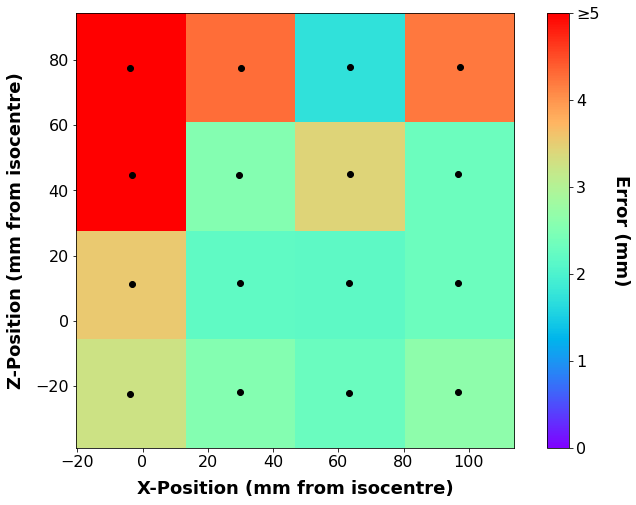

Saving error data from each catheter to: ../reports/export/static/Y0_SRI_Original_centroid_around_peak.h5
Tip Tracking Error @ Y = 45mm sequence SRI_Original, algorithm png


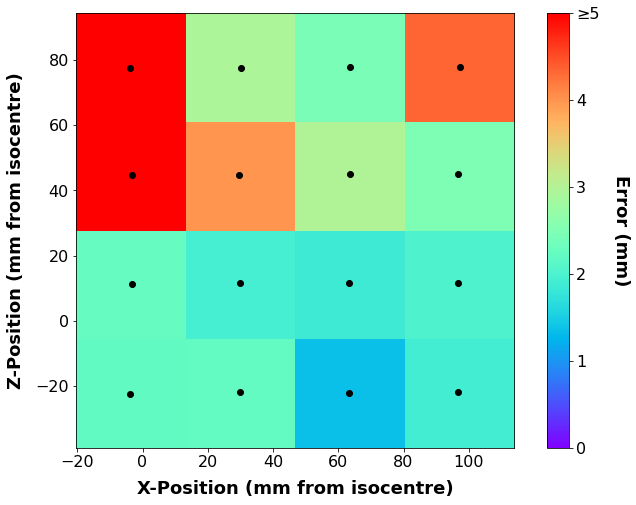

Saving error data from each catheter to: ../reports/export/static/Y0_SRI_Original_png.h5
Tip Tracking Error @ Y = 45mm sequence SRI_Original, algorithm jpng


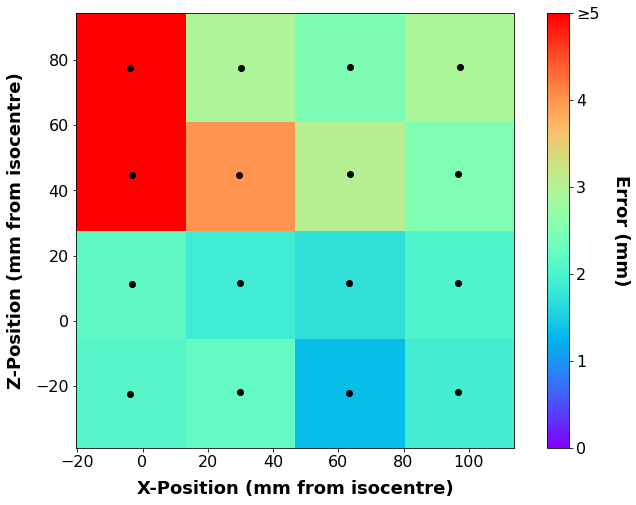

Saving error data from each catheter to: ../reports/export/static/Y0_SRI_Original_jpng.h5
Tip Tracking Error @ Y = 45mm sequence FH512_noDither_gradSpoiled, algorithm centroid_around_peak


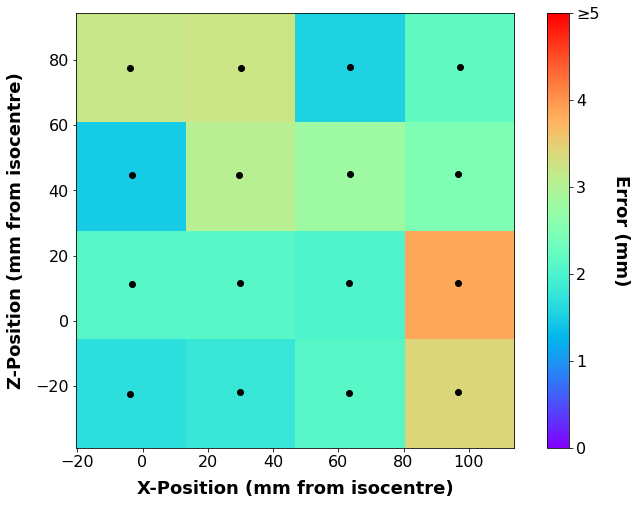

Saving error data from each catheter to: ../reports/export/static/Y0_FH512_noDither_gradSpoiled_centroid_around_peak.h5
Tip Tracking Error @ Y = 45mm sequence FH512_noDither_gradSpoiled, algorithm png


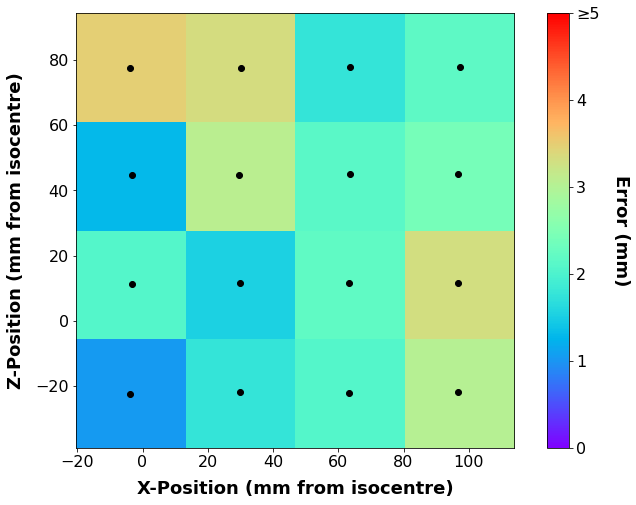

Saving error data from each catheter to: ../reports/export/static/Y0_FH512_noDither_gradSpoiled_png.h5
Tip Tracking Error @ Y = 45mm sequence FH512_noDither_gradSpoiled, algorithm jpng


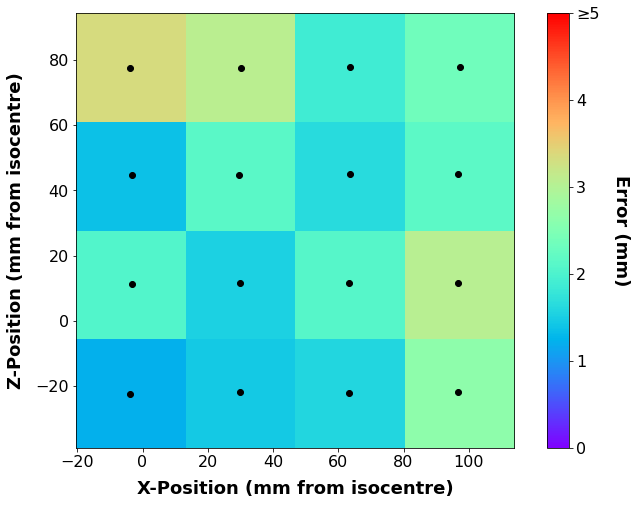

Saving error data from each catheter to: ../reports/export/static/Y0_FH512_noDither_gradSpoiled_jpng.h5
Looking at catheter tip errors for static_err_FH512_noDither_gradSpoiled_jpng_trackTest-13Dec2021-C306-Y0
 from the file: ../reports/export/static/Y0_FH512_noDither_gradSpoiled_jpng.h5
[[ -4.11735429 -25.26670366   2.04933956]
 [ 29.38422917 -24.59971142   2.58762575]
 [ 63.34584573 -25.11686353   2.15496231]
 [ 96.73596105 -25.11379297   2.0045324 ]
 [ 96.42736906   9.06080207   3.19253345]
 [ 63.35335427   9.29856043   1.88171727]
 [ 29.05912293   9.36359524   1.38893776]
 [ -3.02045279   9.10442112   2.74878707]
 [ -3.3899415   42.09594271   1.59333643]
 [ 29.21686143  41.85490123   2.42199247]
 [ 62.72071372  42.53092211   1.3130036 ]
 [ 96.12752384  42.61795678   1.69023515]
 [ 96.65405291  74.54491351   2.56071546]
 [ 63.40070962  74.73256033   2.64645706]
 [ 29.45569108  74.99019766   3.3313431 ]
 [ -3.8995141   75.11147972   4.27571103]]


In [28]:
%cd Static_Tracking
!pwd
%run static_tracking_heatmaps_Y0.ipynb

In [29]:
!pwd

/code/Static_Tracking
